In [1]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [2]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[0]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [24]:
dir0  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6tdiff_dt10/'

file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [25]:
#get files psi
pfile = dir0 + file0


f = netcdf.netcdf_file(dir0 + file0,'r')

In [27]:
#size

si_t = f.variables['time'][:].copy().size

p = qg.read_qgcm(pfile, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nz,ny,nx = p.shape

In [28]:
%%time
# compute means 


p_me = np.zeros((nz,ny,nx))
p_me_avc = np.zeros((nz,ny,nx))


n_me = 1

for it in range(0,si_t):
  
    p = qg.read_qgcm(pfile, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_avc = qg.read_qgcm(pfile, it, var='p', rescale = 1/f0, interp = True, subtract_bc = False)
    
    p_me += (p - p_me)/n_me
    p_me_avc += (p_avc - p_me_avc)/n_me
    
    n_me += 1

CPU times: user 33.1 s, sys: 1.54 s, total: 34.7 s
Wall time: 4min 55s


In [29]:
#other mean quantities derived from the mean streamfunction

u_me,v_me = qg.comp_vel(p_me, Delta=Delta, loc='center')
u_me_avc, v_me_avc = qg.comp_vel(p_me_avc, Delta=Delta, loc='center')

b_me = qg.p2b(p_me, dh, f0)
b_me_avc = qg.p2b(p_me_avc, dh, f0)

In [46]:
#MPE to EPE

p = qg.read_qgcm(pfile, 100, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
p_avc = qg.read_qgcm(pfile, 100, var='p', rescale = 1/f0, interp = True, subtract_bc = False)
    
u,v = qg.comp_vel(p, Delta=Delta, loc='center')
u_avc,v_avc = qg.comp_vel(p_avc, Delta=Delta, loc='center')
    
b = qg.p2b(p, dh, f0)
b_avc = qg.p2b(p_avc, dh, f0)
  
    
u_p = u - u_me
v_p = v - v_me
b_p = b - b_me
p_p = p - p_me

u_p_avc = u_avc - u_me_avc
v_p_avc = v_avc - v_me_avc
b_p_avc = b_avc - b_me_avc
        
u_p_use = reduce_z_dim(u_p, dh)
v_p_use = reduce_z_dim(v_p, dh)
u_p_avc_use = reduce_z_dim(u_p_avc, dh)
v_p_avc_use = reduce_z_dim(v_p_avc, dh)
p_p_use = reduce_z_dim(p_p, dh)

#calcul sens physique avec et sans soustraction des bords
u_b_p = u_p_use*b_p
v_b_p = v_p_use*b_p
    
u_b_p_avc = u_p_avc_use*b_p_avc
v_b_p_avc = v_p_avc_use*b_p_avc
    
mpe2epe = -(b_me/N2[:,None,None])*(div_x(u_b_p, Delta)+div_y(v_b_p,Delta))
mpe2epe_avc = -(b_me_avc/N2[:,None,None])*(div_x(u_b_p, Delta)+div_y(v_b_p,Delta))

#calcul référence pour le cycle

rec_pe = -(b_me/N2[:,None,None])*qg.jacobian(p_p_use,b_p,Delta)


In [47]:
tran = 365*86400/(0.01**2)
print('Mean value for rel cycle should be: 85')
print('')
print('abs, bc substracted  :',qg.integral(mpe2epe,dh,Delta,average=True)*tran)
print('abs, bc included     :',qg.integral(mpe2epe_avc,dh,Delta,average=True)*tran)
print('abs, reference value :',qg.integral(rec_pe,dh,Delta,average=True)*tran)

Mean value for rel cycle should be: 85

abs, bc substracted  : -232.6017074254607
abs, bc included     : -232.60170725282168
abs, reference value : -194.1357289903661


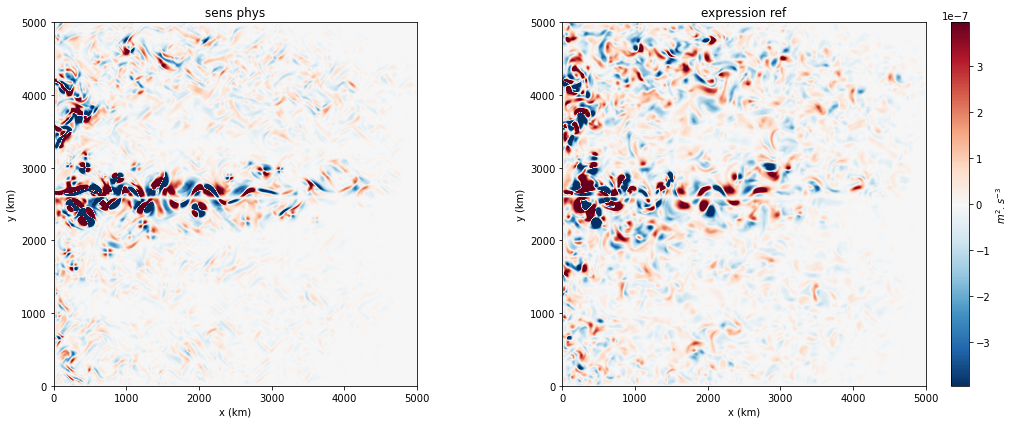

In [48]:
#plots
mpe2epe_i = -integral_z(mpe2epe, dh, Delta, Ht)
rec_pe_i = -integral_z(rec_pe,dh,Delta,Ht_b)


maxi = max(np.max(mpe2epe_i),np.abs(np.min(mpe2epe_i)))


fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize = (15,6),tight_layout=True)


col = ax1.imshow(mpe2epe_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/20, vmin = -maxi/20)
ax1.set_aspect('equal')
ax1.set_title(' sens phys ')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')


col2 = ax2.imshow(rec_pe_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/20, vmin = -maxi/20)
ax2.set_aspect('equal')
ax2.set_title('expression ref')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')


#cax = plt.axes([1, 0.05, 0.035, 0.9])

m2 = plt.cm.ScalarMappable(cmap='RdBu_r')
m2.set_array(mpe2epe_i)
m2.set_clim(-maxi/20, maxi/20)
plt.colorbar(m2,ax=ax2).set_label(r'$m^2.s^{-3}$')